# Autoregressiv model


# Spectral Estimation - Benjamin Cohen

In [12]:
#Librairies
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.signal
import scipy as sp
import pylab as pl
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pmd
from scipy.io import wavfile


## 1. Processus autorégressif

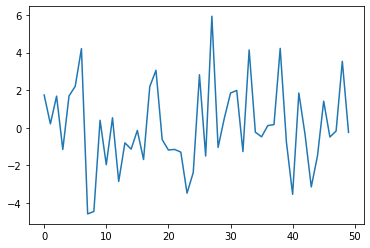

In [13]:
#Question 1.1 : Synthèse
plt.close()
def AR_list(n_samples,sigma,coeff_ar):
        #np.random.seed(1)
        x = w = np.random.normal(size=n_samples) #initialisation aléatoire des coefficients suivant une loi gaussienne
        for t in range(n_samples):
            for i in range (len(coeff_ar)):
                if (t-i<0):
                    break
                else:
                    x[t]+= coeff_ar[i]*x[t-i] + np.random.normal(0,sigma)
        return x

plt.plot(AR_list(50,1,[0.9]))

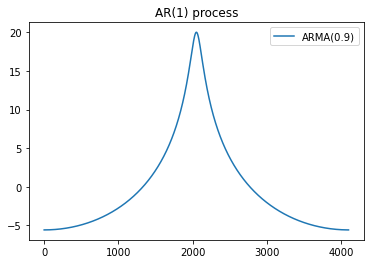

In [14]:
#Other way 

import spectrum.arma
from pylab import plot, log10, legend
plt.plot(10*log10(spectrum.arma.arma2psd([0.9])), label='ARMA(0.9)')
legend()
plt.title('AR(1) process')
plt.show()

### 1.2. Estimation non-paramétrique : périodogramme

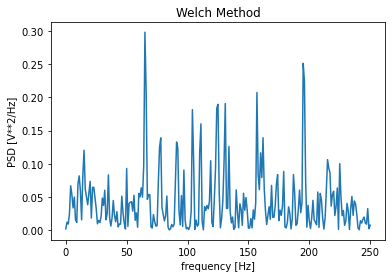

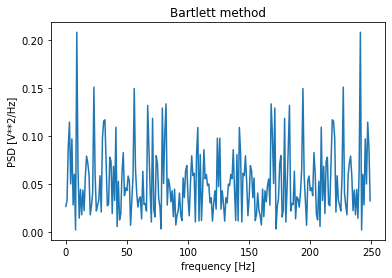

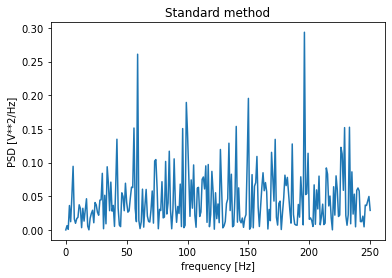

In [15]:
#Question 1.2.2 : Afficher périodogramme

from numpy.linalg import norm

def display_perio(sig,method):
    if method == 'welch' :
        f, Pxx_den = sp.signal.welch(sig, nperseg=len(sig))
        Pxx_den = [(x/norm(Pxx_den, ord=2)) for x in Pxx_den] #Normalisation des données avec la norme 2
        return(f,Pxx_den)
    elif method == 'Bartlett' :  
        M = 250
        N = len(sig)
        L = N // M
        somme = 0
        for i in range(L) :
            sig_tilde = sig[i*M:(i+1)*M]
            somme += np.abs(np.fft.fft(sig_tilde))**2 
        Sp_sig = somme / N
        nu = 2 * np.pi * np.arange(M) / M
        Sp_sig = [(x/norm(Sp_sig, ord=2)) for x in Sp_sig] #Normalisation des données avec la norme 2
        return(nu, Sp_sig)
    else :
            f, Pxx_den = sp.signal.periodogram(sig)
            Pxx_den = [(x/norm(Pxx_den, ord=2)) for x in Pxx_den] #Normalisation des données avec la norme 2
            return(f,Pxx_den)

plt.plot(display_perio(AR_list(500,1,[0.7]),'welch')[1])
plt.title('Welch Method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
plt.plot(display_perio(AR_list(500,1,[0.7]),'Bartlett')[1])
plt.title('Bartlett method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
plt.plot(display_perio(AR_list(500,1,[0.7]),'')[1])
plt.title('Standard method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

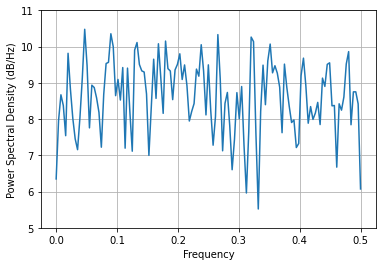

In [16]:
from spectrum import *
psd = WelchPeriodogram(AR_list(5000,1,[0.7]), 256)


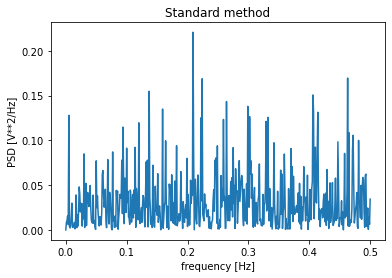

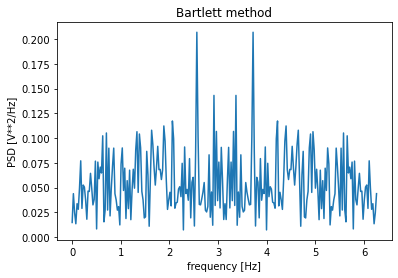

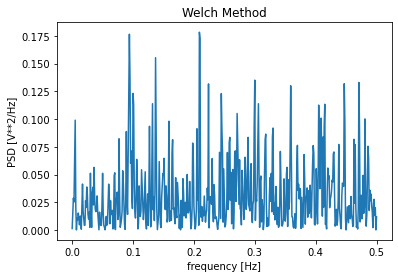

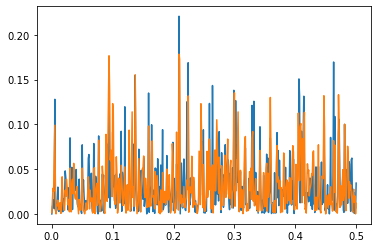

In [17]:
#Question 1.2.3
#test=AR_list(50000,1,[0.7])
test=AR_list(1000,2,[0.9])
plt.figure()
a=display_perio(test,'')
plt.plot(a[0],a[1])
plt.title('Standard method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

c=display_perio(test,'Bartlett')
plt.plot(c[0],c[1])
plt.title('Bartlett method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

b=display_perio(test,'welch')
plt.plot(b[0],b[1])
plt.title('Welch Method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

# On construit le periodograme de test avec notre fonction pour les 3 methodes

nu_s , Sp_s = display_perio(test, 'Standard')
nu_b , Sp_b = display_perio(test, 'Bartlett')
nu_w , Sp_w = display_perio(test, 'welch')


plt.plot(nu_s, Sp_s)
plt.plot(nu_w,Sp_w)
#plt.plot(nu_b, Sp_b) probleme de normalisation
plt.show()

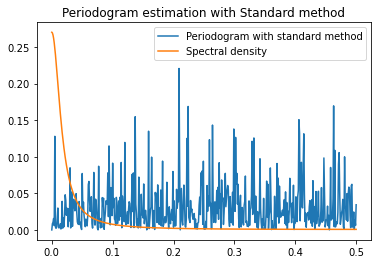

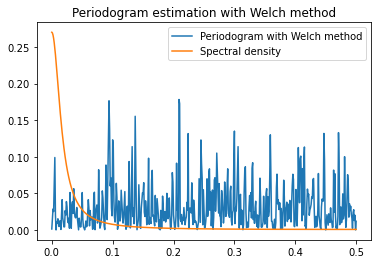

In [18]:
# Superpostion avec la densité spectrale connue.

def DSP(nu, sigma, a1) :
    i = complex(0,1)
    expr = 1 - a1 * np.exp(-2*i*np.pi*nu)
    return(sigma**2 / (np.linalg.norm(expr)**2))

DSP_ = [DSP(nu, 1, 0.9) for nu in nu_s]
DSP_nor = [(x/norm(DSP_, ord=2)) for x in DSP_]
plt.plot(nu_s, Sp_s, label="Periodogram with standard method")
plt.plot(nu_s, DSP_nor, label = "Spectral density")
plt.title("Periodogram estimation with Standard method")
plt.legend()
plt.show()

DSP_w = [DSP(nu, 1, 0.9) for nu in nu_w]
DSP_wnor = [(x/norm(DSP_w, ord=2)) for x in DSP_w]
plt.plot(nu_w, Sp_w, label="Periodogram with Welch method")
plt.plot(nu_w, DSP_wnor, label = "Spectral density")
plt.title("Periodogram estimation with Welch method")
plt.legend()
plt.show()

In [19]:
#Question 1.2.4

print('Biais méthode standard =' ,np.mean(Sp_s[1] - DSP_nor))
print('Variance méthode standard =', np.mean((Sp_s[1] - DSP_nor - np.mean(Sp_s[1] - DSP_nor))**2))

print('Biais méthode welch =' ,np.mean(Sp_w[1] - DSP_wnor))
print('Variance méthode welch =', np.mean((Sp_w[1] - DSP_wnor - np.mean(Sp_w[1] - DSP_wnor))**2))


Biais méthode standard = -0.006033879466895479
Variance méthode standard = 0.001786785065784682
Biais méthode welch = -0.0005063520715580564
Variance méthode welch = 0.0017867850657846823


### 1.3. Estimation paramétrique : prédiction linéaire

In [20]:
#Question 1.3.5 / Estimation du modèle
def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray,start_p=2 ,start_q=0 ,test="adf",trace=True)
    return autoarima_model

#Test sur un modele AR(1)
arima_model = arimamodel(AR_list(10000,1,[0.4,-0.5]))
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=42197.621, Time=1.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=45198.379, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=42195.644, Time=0.95 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=42787.369, Time=2.36 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=45196.417, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=42197.621, Time=1.43 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=42199.644, Time=3.71 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=42193.773, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=42195.750, Time=0.44 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=42195.750, Time=0.38 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=42785.542, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=42197.773, Time=2.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 13.931 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -21094.886
Date:                Sun, 21 Mar 2021   AIC                          42193.773
Time:                        18:01:58   BIC                          42208.194
Sample:                             0   HQIC                         42198.654
                              - 10000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5095      0.008    -60.417      0.000      -0.526      -0.493
sigma2         3.9792      0.056     71.346      0.000       3.870       4.088
===================================================================================
Ljung-Box (Q):                       46.64   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.22   Prob(JB):                         0.31
Heteroskedasticity (H):               1.06   Skew:                             0.03
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# On peut également utiliser les équations de Yule Walker :

def Autocorr(X, p) :
    "Retourne les covariances empiriques d'un signal X"
    N = len(X)
    cov = np.zeros(p+1)
    for k in range(p+1) :
        somme = 0
        for j in range(N-k) :
            somme += X[j-k]*X[j]
        cov[k] = (1/N)*somme
    return(cov)    

def AR_est(X, p) :
    """Renvoie les coefficients AR(p) estimés du signal X"""
    cov = Autocorr(X,p)
    Rxx = sp.linalg.toeplitz(cov[:p])
    r = cov[1:p+1]
    coeff =  sp.linalg.inv(Rxx).dot(r)
    return(coeff)

# Application sur l'exemple précédent :

t_coeffs = [0.6,0.9]
coeffs_est = AR_est(AR_list(10000,1,[0.9,0.6]), 2)
print(coeffs_est)
err = np.abs(coeffs_est-t_coeffs)/np.abs(t_coeffs)
print(err)

# On obtient de petites erreurs sur le premier coefficient mais les autres coefficients dévient ce que on attendait

[0.58281279 0.01248234]
[0.02864535 0.98613073]


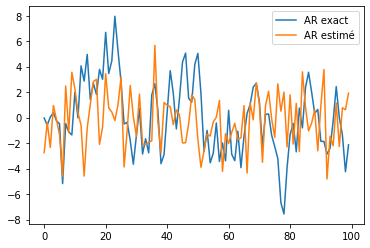

In [22]:
#Question 1.4.6

test_2 = AR_list(100,1,[0.9,0.6])
test_2_est = AR_list(100,1,coeffs_est)
nu2_s, Sp2_s = display_perio(test_2,'Standard')

plt.plot(test_2, label="AR exact")
plt.plot(test_2_est, label="AR estimé")
plt.legend()
plt.show()

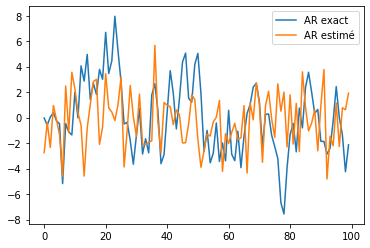

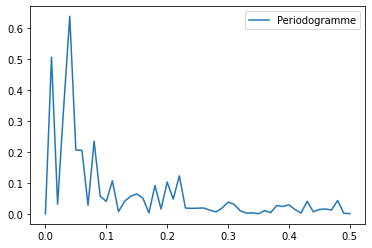

In [23]:
test_2_mn = AR_list(1000,1,[0.9,0.6])
test_2_est_mn = AR_list(1000,1,coeffs_est)
nu2_s, Sp2_s = display_perio(test_2,'Standard')

plt.plot(test_2, label="AR exact")
plt.plot(test_2_est, label="AR estimé")
plt.legend()
plt.show()
plt.plot(nu2_s,Sp2_s , label ="Periodogramme")
plt.legend()

### 1.4 Application à des signaux de parole


In [89]:
#Question 1.4.7 : 

from scipy.io import wavfile
samplerate, data = wavfile.read('./aeiou.wav')
# On regarde le signal aeiou.wav pour ne garder que le premier 'a' pour se faire on s'arrête au 13 000eme point du signal 

sound_a = data[2000:13000].astype(float)
coeff_est = AR_est(sound_a,30)
sound_est = AR(11000, sound_a[2000:2030], 2, coeff_est)
nu_sound, Sp_sound = display_perio(sound_est, 'Standard')

plt.figure(figsize=(20,10))
plt.plot(nu_sound,data[2000:13000], label = "Sound data")
plt.plot(nu_sound, sound_est, label= "Estimated sound")
plt.plot(nu_sound, Sp_sound, label = "Estimated Periodogram")
plt.legend()
plt.show()

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-89-5739b5c9e2c0>, line 4)

# 2. Somme de sinusoïdes bruitées


In [25]:
#Question 2.1

def synth_sig(t,freq,amp,phases,sigma):
    N = len(freq)
    X=0
    for i in range(N):
        X+= amp[i]*np.sin(freq[i]*t + phases[i])
    X+= np.random.normal(0,sigma)
    return X

print(synth_sig(5,[400,500],[1,1],[0,0],1))

-1.3876713505803693


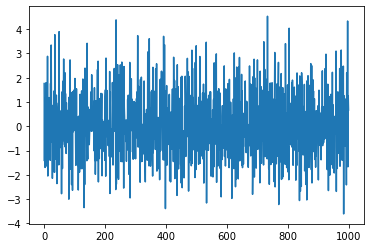

In [26]:
#Question 2.2

sig = []
sigma = 1
for i in range(int(10e2)):
    sig.append(synth_sig(i,[400,500],[1,1],[0,0],sigma))
plt.plot(sig)


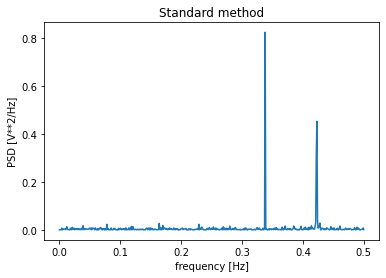

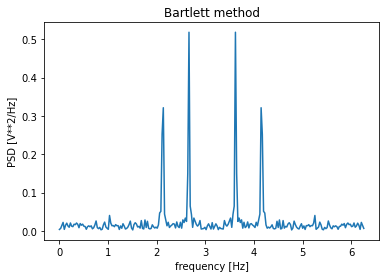

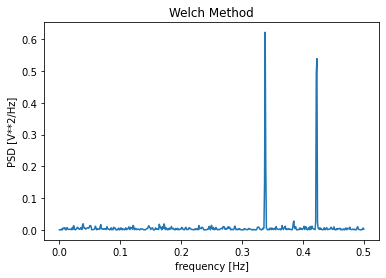

In [27]:
plt.figure()
a=display_perio(sig,'')
plt.plot(a[0],a[1])
plt.title('Standard method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

c=display_perio(sig,'Bartlett')
plt.plot(c[0],c[1])
plt.title('Bartlett method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

#La méthode de Bartlett est fausse sûrement due à une erreur dans mon code.

b=display_perio(sig,'welch')
plt.plot(b[0],b[1])
plt.title('Welch Method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

deltanu=20 Hz


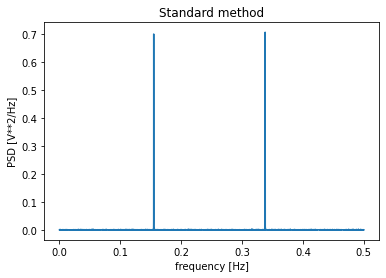

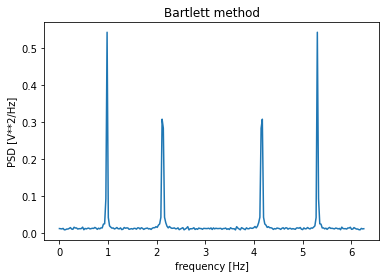

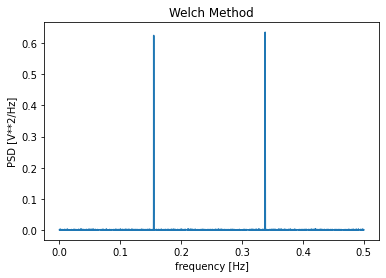

deltanu=5 Hz


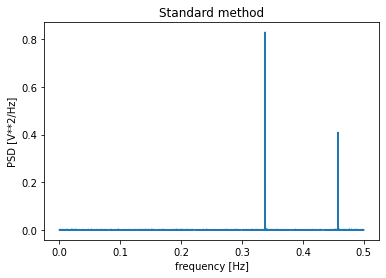

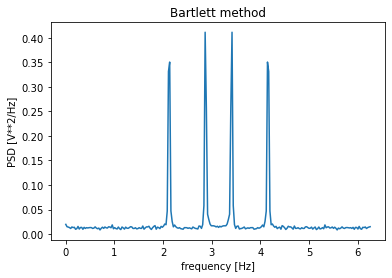

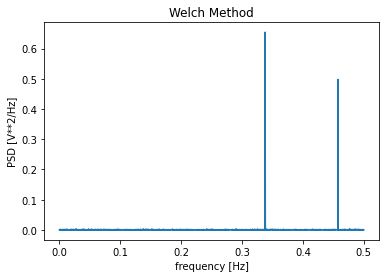

deltanu=3 Hz


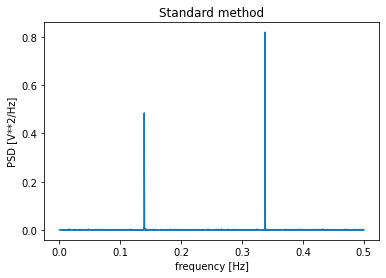

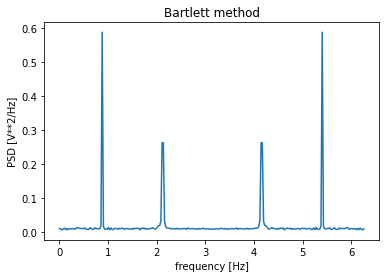

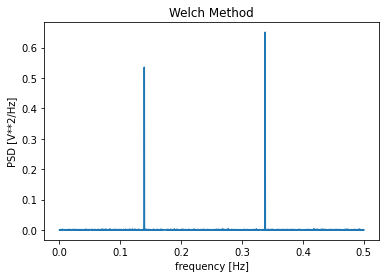

In [28]:
#Question 2.3 : Afficher différents périodogrammes en modifiant la différence de fréquence des signaux d'entrée

print('deltanu=20 Hz')
sig = []
sigma = 1
for i in range(int(10e3)):
    sig.append(synth_sig(i,[400,420],[1,1],[0,0],sigma))
    
plt.figure()
a=display_perio(sig,'')
plt.plot(a[0],a[1])
plt.title('Standard method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

c=display_perio(sig,'Bartlett')
plt.plot(c[0],c[1])
plt.title('Bartlett method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

b=display_perio(sig,'welch')
plt.plot(b[0],b[1])
plt.title('Welch Method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

print('deltanu=5 Hz')
sig = []
sigma = 1
for i in range(int(10e3)):
    sig.append(synth_sig(i,[400,405],[1,1],[0,0],sigma))
    
plt.figure()
a=display_perio(sig,'')
plt.plot(a[0],a[1])
plt.title('Standard method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

c=display_perio(sig,'Bartlett')
plt.plot(c[0],c[1])
plt.title('Bartlett method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

b=display_perio(sig,'welch')
plt.plot(b[0],b[1])
plt.title('Welch Method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

print('deltanu=3 Hz')
sig = []
sigma = 1
for i in range(int(10e3)):
    sig.append(synth_sig(i,[400,403],[1,1],[0,0],sigma))
    
plt.figure()
a=display_perio(sig,'')
plt.plot(a[0],a[1])
plt.title('Standard method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

c=display_perio(sig,'Bartlett')
plt.plot(c[0],c[1])
plt.title('Bartlett method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

b=display_perio(sig,'welch')
plt.plot(b[0],b[1])
plt.title('Welch Method')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()


In [29]:
#Question 2.3.4
arima_model = arimamodel(AR_list(10000,1,[0.9,0.8,-0.5,0.7]))
df = pd.DataFrame(arima_model.predict(10000))
df.head()

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=48663.867, Time=1.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55387.439, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55254.322, Time=0.56 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=53494.574, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=55385.487, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=48664.916, Time=1.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=48664.949, Time=1.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=53109.597, Time=3.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=48667.143, Time=2.88 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=48662.237, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=55252.385, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=48663.293, Time=1.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=48663.325, Time=1.33 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=53108.190, Time=1.80 sec
 ARIMA(3,1,1)(0,0,0

,0
0,86.304389
1,89.434595
2,89.295586
3,87.147766
4,87.666082


[ 0.66907873 -0.10116493  0.23174945 ... -0.39103195 -1.48281482
  2.80169203]


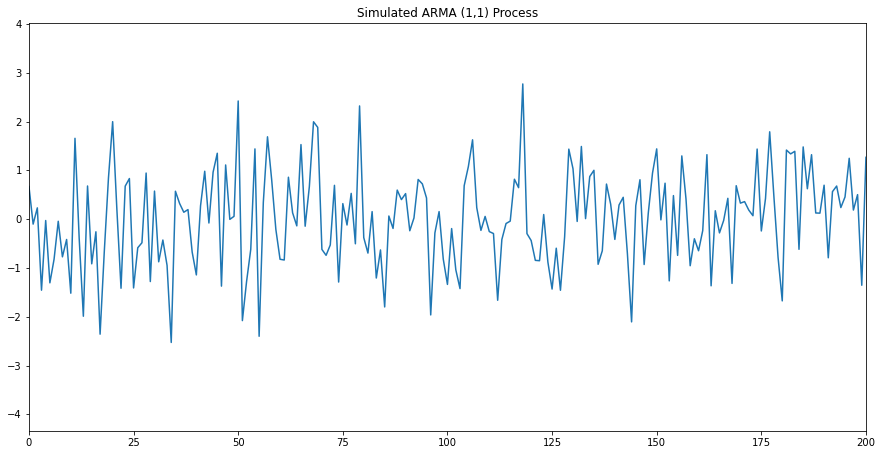

In [30]:
#Question 3.1
from statsmodels.tsa.arima_process import ArmaProcess

def ARMA(sigma,coeff_ar,coeff_ma):
    simulated_ARMA_data = ArmaProcess(coeff_ar, coeff_ma).generate_sample(nsample=10000)
    return simulated_ARMA_data 

arma_1 = ARMA(1,[1,1],[1,1])
print(arma_1)
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(arma_1)
plt.title("Simulated ARMA (1,1) Process")
plt.xlim([0, 200])
plt.show()

Méthode standard


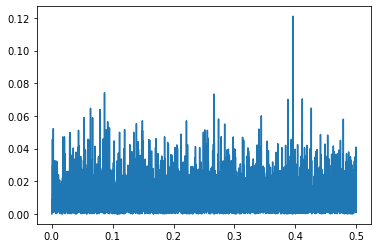

In [31]:
#Question 3.2
print("Méthode standard")
plt.plot(display_perio(arma_1, '')[0],display_perio(arma_1, '')[1])

Méthode Welch


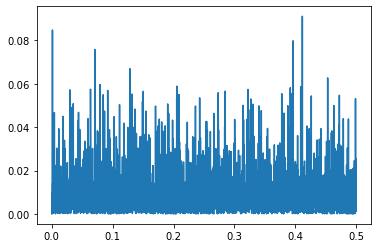

In [32]:
print("Méthode Welch")
plt.plot(display_perio(arma_1, 'welch')[0],display_perio(arma_1, 'welch')[1])

Méthode Bartlett


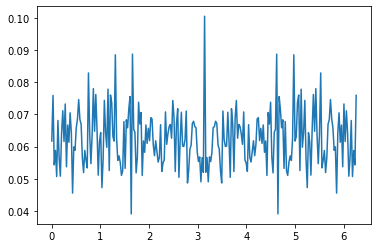

In [33]:
print("Méthode Bartlett")
plt.plot(display_perio(arma_1, 'Bartlett')[0],display_perio(arma_1, 'Bartlett')[1])

[-0.00643913  0.00604361]


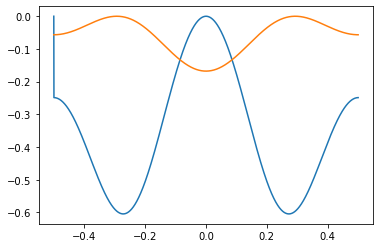

In [77]:
#Question 3.3.4

#Moving average estimator
from spectrum import arma2psd, ma, marple_data
import pylab
b, rho = ma(display_perio(arma_1, 'Standard')[1] , 2, 60)
psd = arma2psd(B=b, rho=rho, sides='centerdc')
pylab.plot(pylab.linspace(-0.5, 0.5, 4096), 10 * log10(psd/max(psd)))

ar, P, k = aryule(arma_1, 2, norm='biased')
print(ar)
psd = arma2psd(ar)
plot(linspace(-0.5, 0.5, 4096), 10 * log10(psd/max(psd)))


Text(0.5, 1.0, 'Real ARMA(2,2) process normalised')

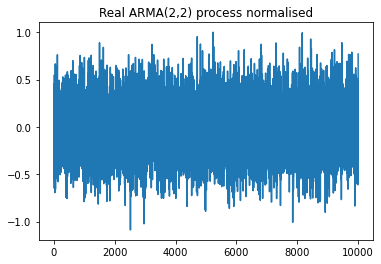

In [74]:
#Question 3.3.5

plt.close()
plot(arma_1/max(arma_1)) #Facteur 1000 pour la normalisation
plt.title('Real ARMA(2,2) process normalized')

Text(0.5, 1.0, 'Estimated ARMA(2,2) process normalised ')

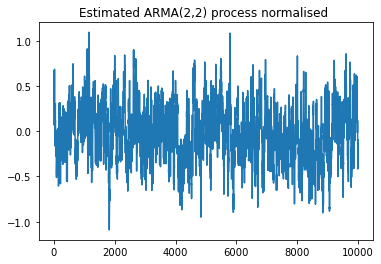

In [75]:
plt.close()
coeffs_arest = ar
plt.plot(ARMA(1,coeffs_arest,[1,1])/max(ARMA(1,coeffs_arest,[1,1])))
plt.title('Estimated ARMA(2,2) process normalised ')

Text(0.5, 1.0, 'Overlap of the real and the estimated ARMA process')

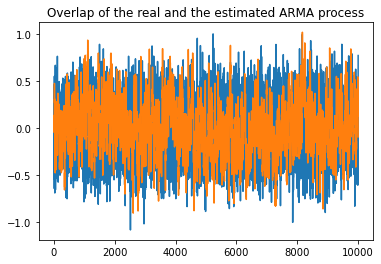

In [76]:
#Superposition
plt.close()
plot(arma_1/max(arma_1)) #Pour la normalisation et avoir des données lisibles
plt.plot(ARMA(1,coeffs_arest,[1,1])/max(ARMA(1,coeffs_arest,[1,1])))
plt.title('Overlap of the real and the estimated ARMA process')